# Introduction

# Libraries

In [1]:
%matplotlib inline

import requests
from bs4 import BeautifulSoup
from bs4 import Comment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data

In [2]:
# URL for website.
url = 'https://www.basketball-reference.com/leagues/NBA_2019.html#all_team-stats-base'

# Send a get request to the URL.
response = requests.get(url)

# Parse the webpage and create a BeautifulSoup object.
soup = BeautifulSoup(response.text, 'html.parser')

# The table we want is stored as a comment in the HTML. We need to extract this as a table.
# Find all PageElements that are comments.
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

# There are multiple tables on the page.
# Convert each table to a pandas dataframe and identify the index of the desired table.
for comment in comments:
   if 'div_team-stats-per_game' in comment:
      team_stats_df = pd.read_html(comment)[0]

# Pre-Processing

In [3]:
# Remove the League Average row from the dataframe.
team_stats_df.drop(team_stats_df[team_stats_df['Team'] == 'League Average'].index, inplace=True)

# The playoff teams have a star next to their team name.
# Find teams with a asterisk in name and creates a new column in the dataframe to represent playoff teams.
team_stats_df['Playoffs'] = np.where(team_stats_df['Team'].str.contains('\*'), 1, 0)

# Remove the asterisk from the team name.
team_stats_df['Name'] = team_stats_df['Team'].str.replace('\*', '', regex=True)

# Examine the dataframe. 
team_stats_df.columns

# Offensive output and offensive efficiency both predict regular season success in the NBA. 
# True shooting percentage (TS) is a better measure of shooting efficiency than field goal percentage (FG%). 
# Add a column for TS, which is given by  PTS / (2 * (FGA + 0.44 * FTA)).
team_stats_df['TS'] = team_stats_df['PTS'] / (2 * (team_stats_df['FGA'] + 0.44 * team_stats_df['FTA']))

# Descriptive Statistics

## Obtain descriptive statistics the three variables of interest: points per game (PTS) and true shooting percentage (TS).


In [4]:
team_stats_df[['PTS', 'TS']].describe()

,PTS,TS
count,30.000000,30.000000
mean,111.203333,0.559533
std,4.093180,0.015063
min,103.500000,0.529267
25%,107.625000,0.550368
50%,112.000000,0.555658
75%,114.350000,0.571163
max,118.100000,0.595793


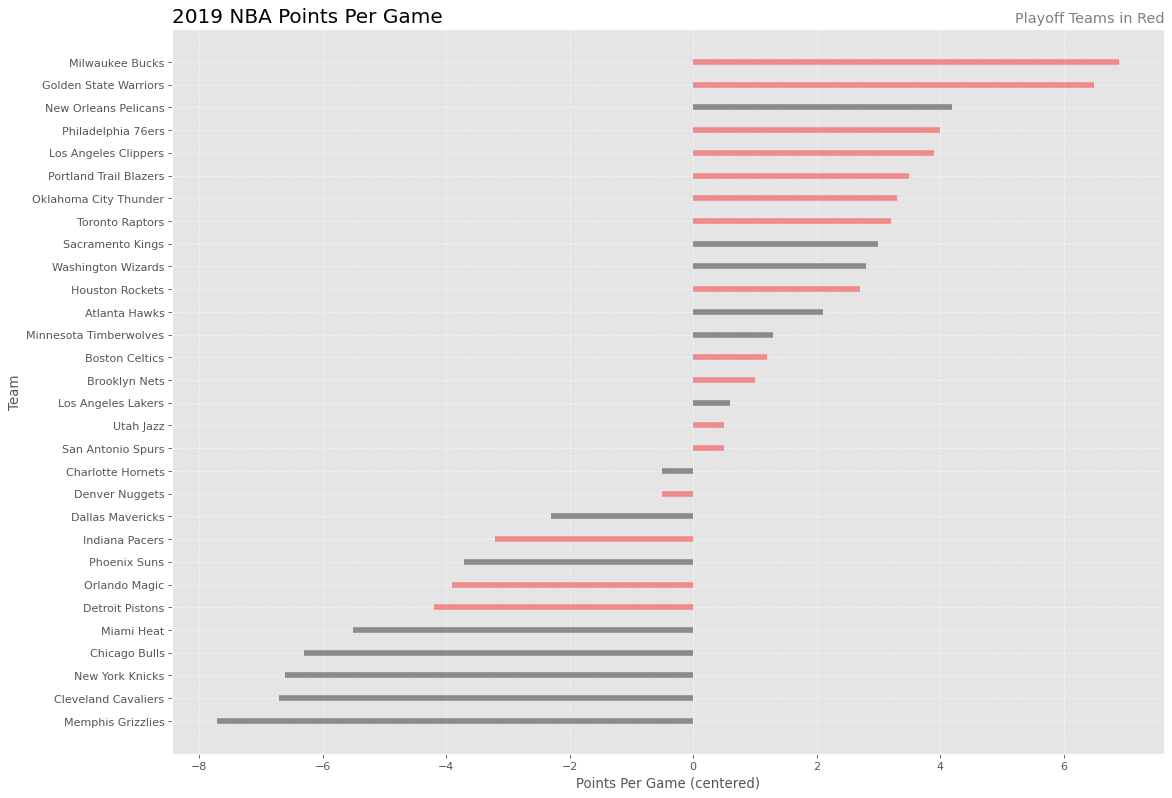

In [5]:
# Plot points per game by playoff appearance.
# Set a plot style.
plt.style.use('ggplot')

# Prepare a new dataframe for the plot.
pts_data = team_stats_df
x = pts_data.loc[:, ['PTS']]
pts_data['PTS_centered'] = (x - x.mean())
pts_data['colors'] = ['red' if x == 1 else 'black' for x in pts_data['Playoffs']]
pts_data.sort_values('PTS_centered', inplace=True)
pts_data.reset_index(inplace=True)

# Draw plot.
plt.figure(figsize=(16,12), dpi= 80)
plt.hlines(y=pts_data.index, xmin=0, xmax=pts_data.PTS_centered, color=pts_data.colors, alpha=0.4, linewidth=5)

# Customize plot. 
plt.gca().set(ylabel='Team', xlabel='Points Per Game (centered)')
plt.yticks(ticks=pts_data.index, labels=pts_data.Name, fontsize=10)
plt.title("2019 NBA Points Per Game", loc='left', fontsize=18)
plt.title("Playoff Teams in Red", loc='right', fontsize=13, color='grey')
plt.grid(linestyle='--', alpha=0.5)

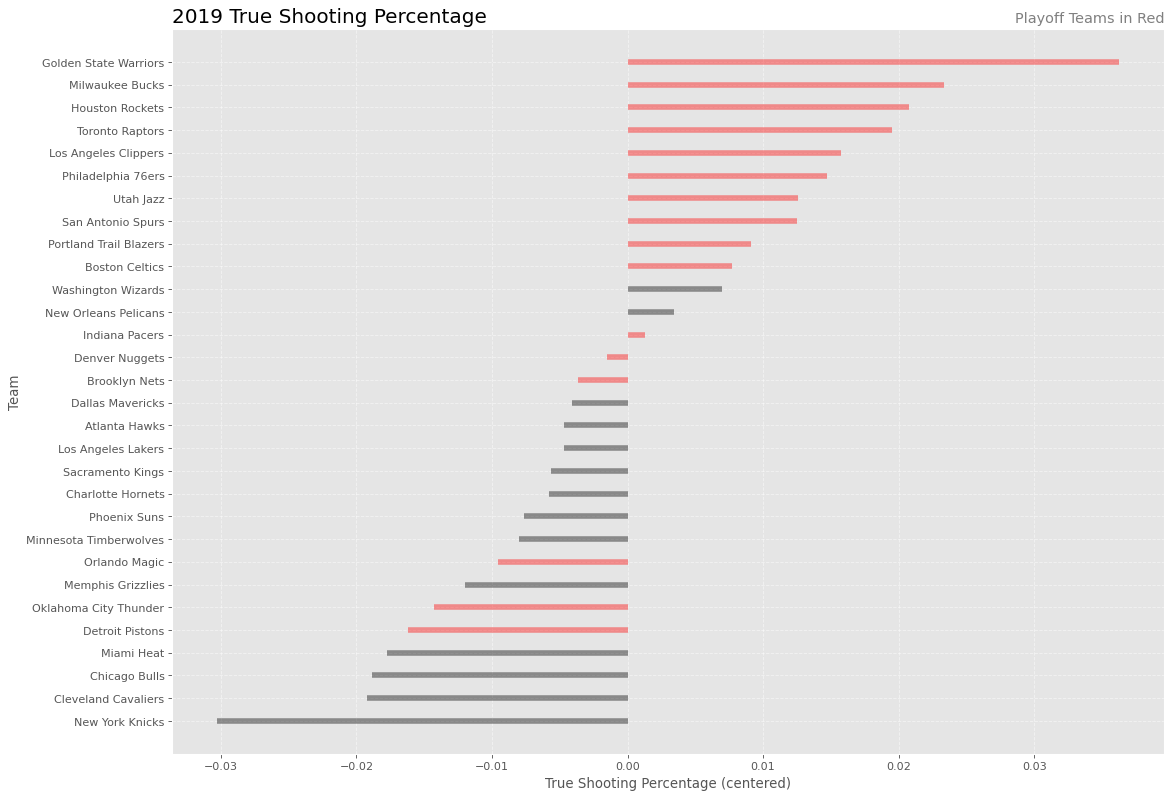

In [6]:
# Plot true shooting percentage by playoff appearance.
# Prepare a new dataframe for the plot.
ts_data = team_stats_df
x = ts_data.loc[:, ['TS']]
ts_data['TS_centered'] = (x - x.mean())
ts_data['colors'] = ['red' if x == 1 else 'black' for x in ts_data['Playoffs']]
ts_data.sort_values('TS_centered', inplace=True)
ts_data.reset_index(inplace=True)

# Draw plot.
plt.figure(figsize=(16,12), dpi= 80)
plt.hlines(y=ts_data.index, xmin=0, xmax=ts_data['TS_centered'], color=pts_data.colors, alpha=0.4, linewidth=5)

# Customize plot. 
plt.gca().set(ylabel='Team', xlabel='True Shooting Percentage (centered)')
plt.yticks(ticks=pts_data.index, labels=pts_data.Name, fontsize=10)
plt.title("2019 True Shooting Percentage", loc='left', fontsize=18)
plt.title("Playoff Teams in Red", loc='right', fontsize=13, color='grey')
plt.grid(linestyle='--', alpha=0.5)

Text(1.0, 1.0, 'Playoff Teams in Red')

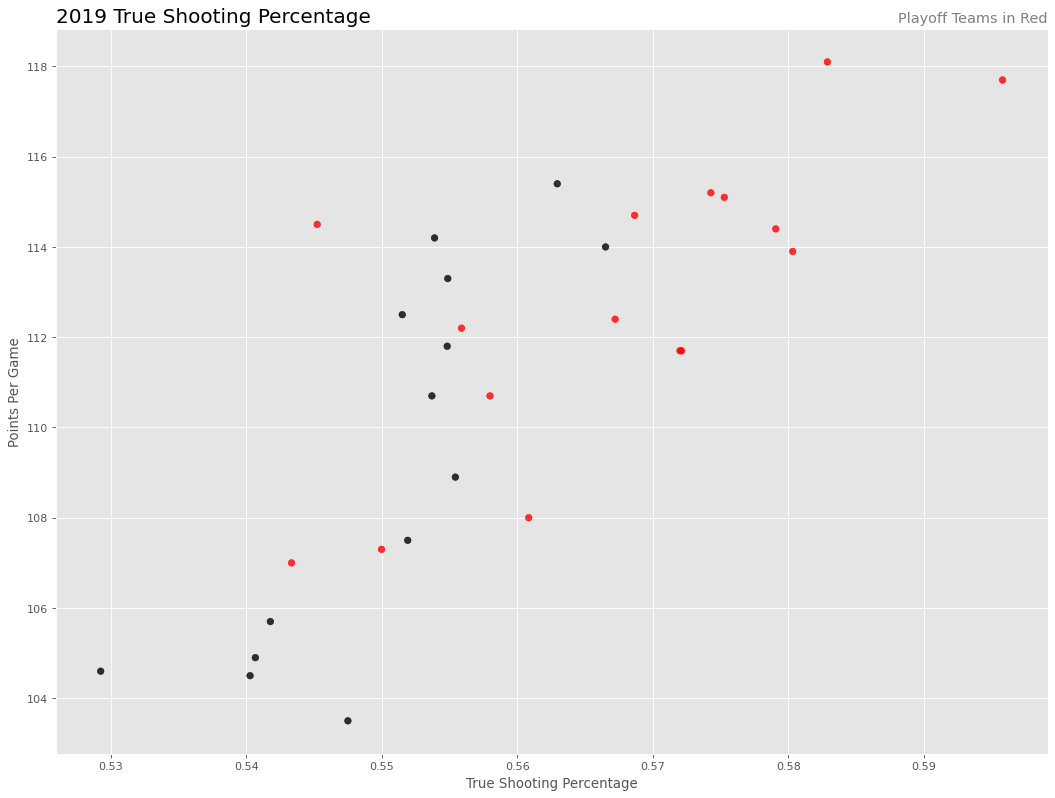

In [7]:
# Plotting the correlation between the two predictors variables: PTS and TS.
# Define color mapping.
colors = {0:'black', 1:'red'}

# Draw plot.
plt.figure(figsize=(16,12), dpi= 80)
plt.scatter(team_stats_df['TS'], team_stats_df['PTS'], alpha=.8, c=team_stats_df['Playoffs'].map(colors))

# Customize plot. 
plt.gca().set(ylabel='Points Per Game', xlabel='True Shooting Percentage')
plt.title("2019 True Shooting Percentage", loc='left', fontsize=18)
plt.title("Playoff Teams in Red", loc='right', fontsize=13, color='grey')

# Data Analysis

In [8]:
# Build model to test whether points per game and true shooting percentage predict a playoff appearance. 
Y = team_stats_df['Playoffs']
X = team_stats_df[['PTS', 'TS']]
X = sm.add_constant(X)
formula = 'Playoffs ~ PTS + TS'

# Fit the model.
model = smf.glm(formula=formula, data=team_stats_df, family=sm.families.Binomial()).fit()

# Print summary of model fit. 
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Playoffs   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14.505
Date:                Sat, 06 Feb 2021   Deviance:                       29.011
Time:                        14:55:08   Pearson chi2:                     27.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -67.7577     25.460     -2.661      0.0